# Analyze Representations in Path-Integrating RNN

Model from "Conformal Isometry of Lie Group Representation in Recurrent Network of Grid Cells" Xu, et al. 2022. (https://arxiv.org/abs/2210.02684)

### Set Up + Imports

In [2]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
#%load_ext jupyter_black

from neurometry.datasets.load_rnn_grid_cells import plot_rate_map
from neurometry.datasets.rnn_grid_cells.scores import GridScorer
import numpy as np
import skdim
import matplotlib.pyplot as plt

from neurometry.dimension.dimension import skdim_dimension_estimation
from neurometry.dimension.dimension import plot_dimension_experiments

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

from tqdm import tqdm


import pickle

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


### Load trained model activations, loss

In [3]:
model_dir = os.getcwd() + "/curvature/grid-cells-curvature/models/xu_rnn/logs/rnn_isometry/20240418-180712/ckpt/activations/"

model_dir = os.path.join(os.getcwd(), "curvature/grid-cells-curvature/models/xu_rnn")

run_dir = os.path.join(model_dir, "logs/rnn_isometry/20240418-180712")

event_file = os.path.join(run_dir, "events.out.tfevents.1713488846.hall.2392205.0.v2")



step = 19500

activations_file = os.path.join(run_dir, f"ckpt/activations/activations-step{step}.pkl")

with open(activations_file, "rb") as f:
    activations = pickle.load(f)

Visualize rate maps

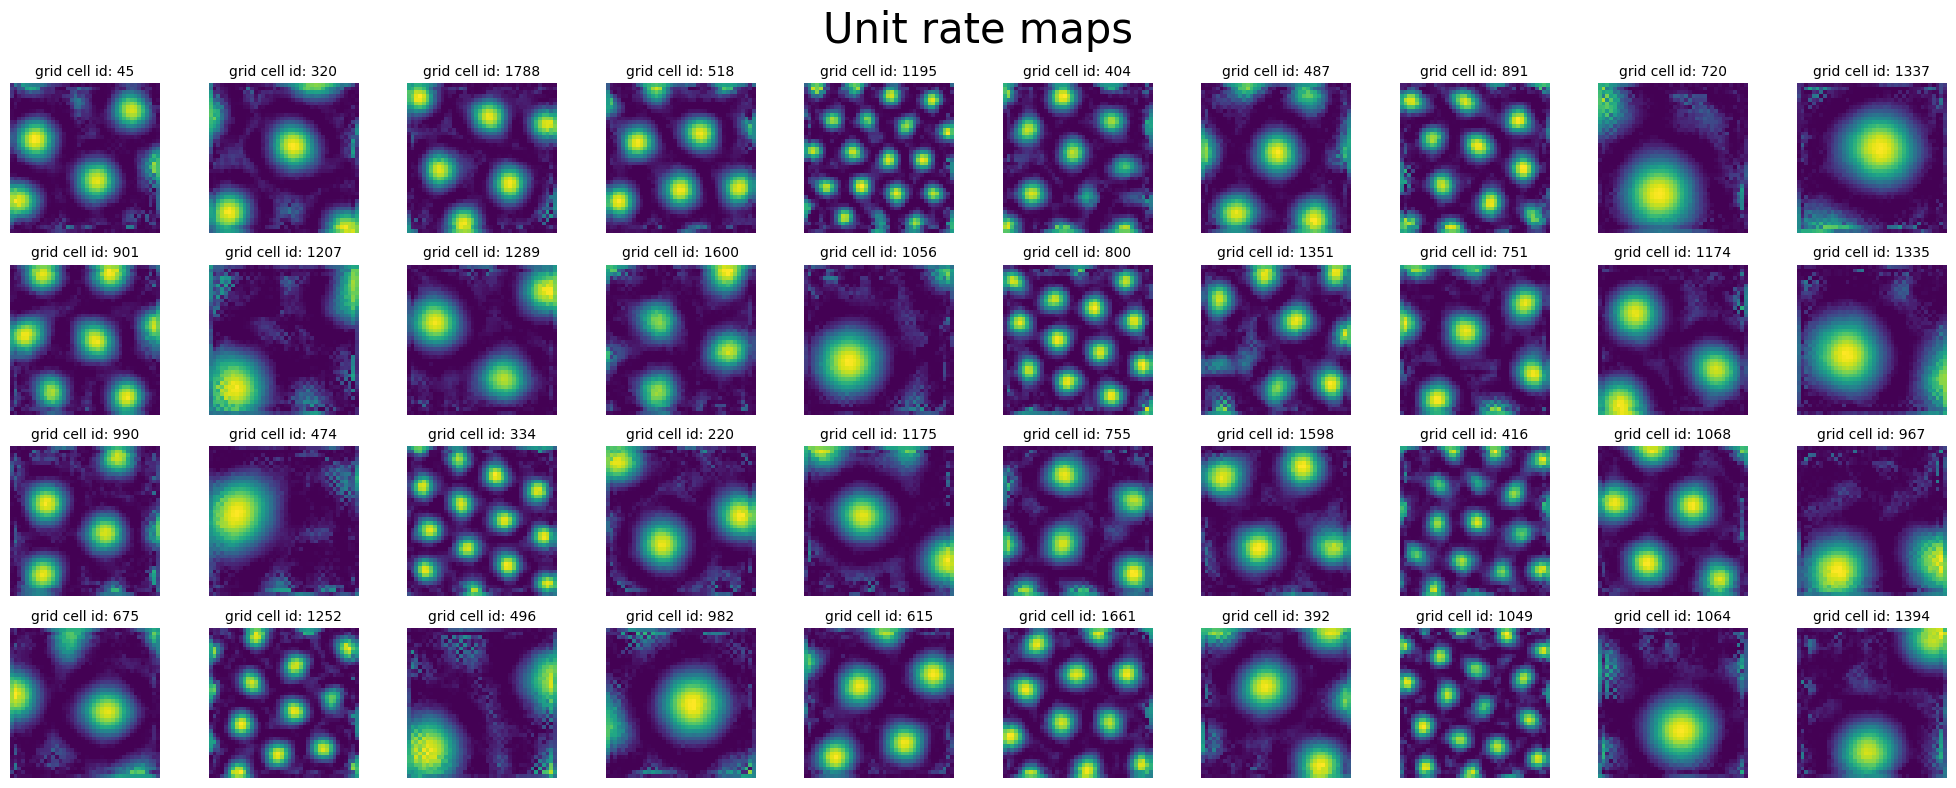

In [3]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map
plot_rate_map(None, 40, activations['v'], "Unit rate maps")

In [4]:
import tensorflow as tf

def extract_tensor_events(event_file, verbose=True):
    records = []
    losses = []
    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            if verbose: print(f"Found event at step {e.step} with wall time {e.wall_time}")
            for v in e.summary.value:
                if verbose: print(f"Found value with tag: {v.tag}")
                if v.HasField("tensor"):
                    tensor = tf.make_ndarray(v.tensor)
                    record = {
                        "step": e.step,
                        "wall_time": e.wall_time,
                        "tag": v.tag,
                        "tensor": tensor,
                    }
                    records.append(record)
                    if v.tag == "loss":
                        loss = {"step": e.step, "loss": tensor}
                        losses.append(loss)
                else:
                    if verbose: print(f"No 'tensor' found for tag {v.tag}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return records, losses


all_tensor_data, losses = extract_tensor_events(event_file, verbose=False)

2024-05-04 15:32:32.649621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 15:32:33.392522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Visualize total loss through training

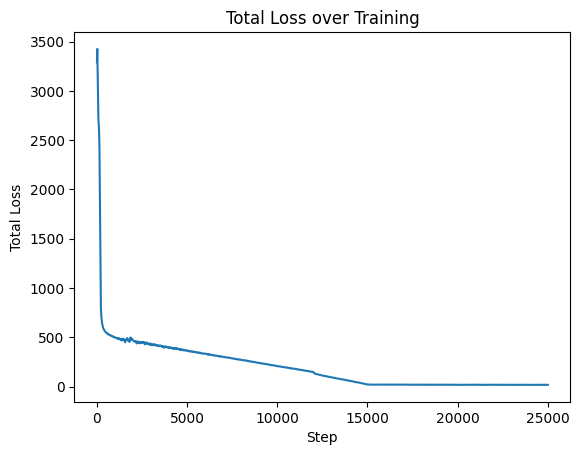

In [5]:
loss_vals = [l["loss"] for l in losses]
loss_steps = [l["step"] for l in losses]

plt.plot(loss_steps, loss_vals)
plt.xlabel("Step")
plt.ylabel("Total Loss")
plt.title("Total Loss over Training");

### Compute grid scores

In [6]:
block_size = 12
num_neurons = 1800
num_block = num_neurons // block_size

starts = [0.1] * 20
ends = np.linspace(0.2, 1.4, num=20)

masks_parameters = zip(starts, ends.tolist())

ncol, nrow = block_size, num_block

scorer = GridScorer(40, ((0, 1), (0, 1)), masks_parameters)

score_list = np.zeros(shape=[len(activations['v'])], dtype=np.float32)
scale_list = np.zeros(shape=[len(activations['v'])], dtype=np.float32)
#orientation_list = np.zeros(shape=[len(weights)], dtype=np.float32)
sac_list = []

for i in range(len(activations['v'])):
    rate_map = activations['v'][i]
    rate_map = (rate_map - rate_map.min()) / (rate_map.max() - rate_map.min())

    score_60, score_90, max_60_mask, max_90_mask, sac, _ = scorer.get_scores(
        activations['v'][i])
    sac_list.append(sac)

    score_list[i] = score_60
    # scale_list[i] = scale
    scale_list[i] = max_60_mask[1]
    # orientation_list[i] = orientation


scale_tensor = torch.from_numpy(scale_list)
score_tensor = torch.from_numpy(score_list)
max_scale = torch.max(scale_tensor[score_list > 0.37])

scale_tensor = scale_tensor.reshape((num_block, block_size))
scale_tensor = torch.mean(scale_tensor, dim=1)

# score_tensor = score_tensor.reshape((num_block, block_size))
score_tensor = torch.mean(score_tensor)
sac_array = np.array(sac_list)

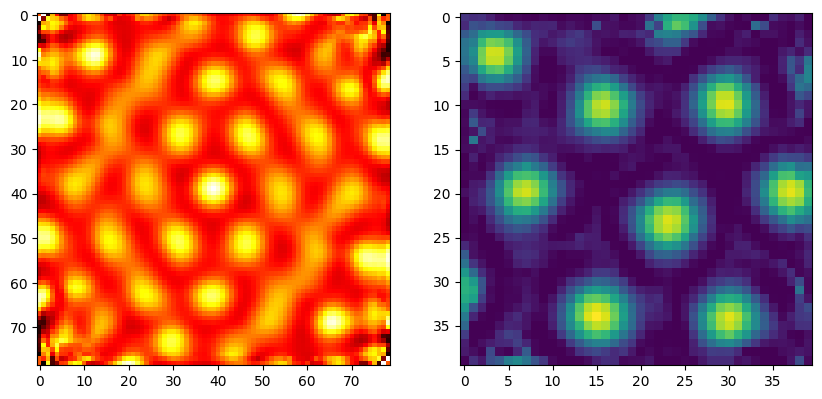

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 631

axes[0].imshow(sac_list[cell_id], cmap="hot");
axes[1].imshow(activations['v'][cell_id]);

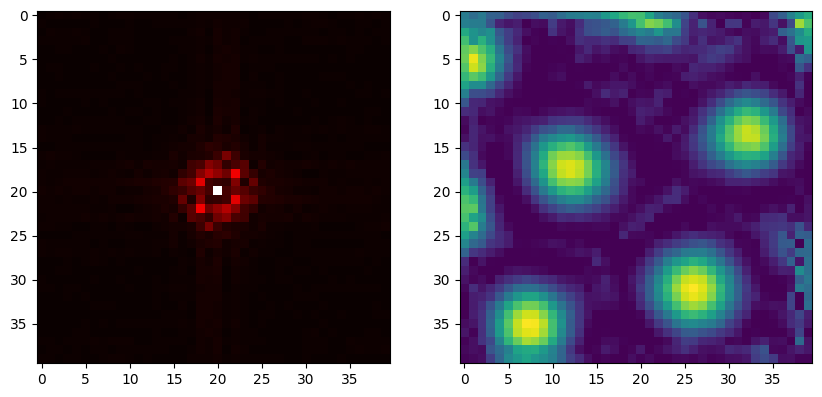

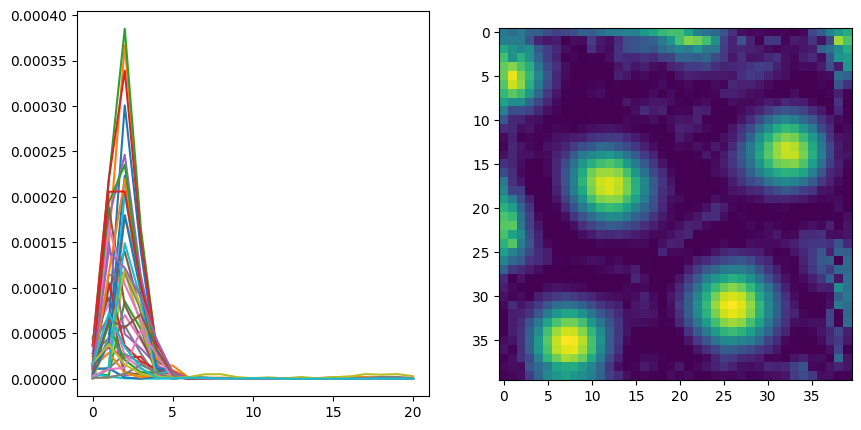

In [8]:
# compute 2D fourier transform of the rate maps

from scipy.fftpack import fft2, fftshift

fft_rate_maps = np.array([fftshift(fft2(rate_map)) for rate_map in activations['v']])

# visualize the 2D fourier transform of the rate map for a single cell

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 201

axes[0].imshow(np.abs(fft_rate_maps[cell_id]), cmap="hot");
axes[1].imshow(activations['v'][cell_id]);

# estimate the spectral density of the rate maps

from scipy.signal import welch

frequencies, psd = welch(activations['v'], fs=40, nperseg=40, axis=1)

# visualize the spectral density of the rate maps for a single cell

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 201 

axes[0].plot(frequencies, psd[cell_id]);

axes[1].imshow(activations['v'][cell_id]);

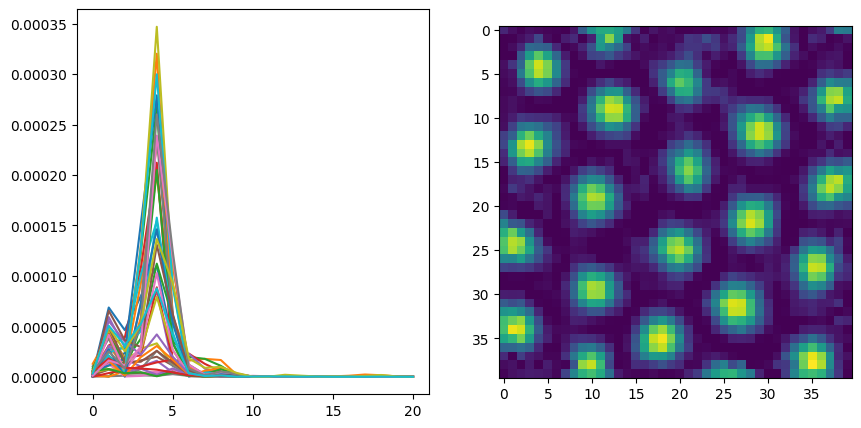

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 1191

axes[0].plot(frequencies, psd[cell_id]);

axes[1].imshow(activations['v'][cell_id]);

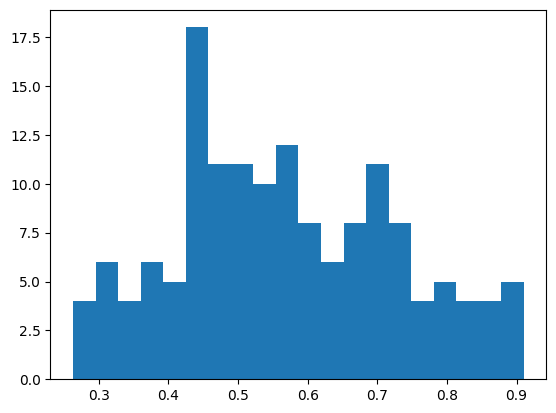

In [9]:
plt.hist(scale_tensor, bins=20);

TypeError: len() of a 0-d tensor

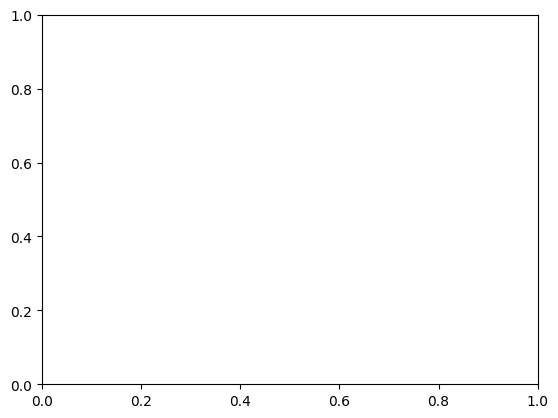

In [10]:
plt.hist(score_tensor);

### Define subpolations based on UMAP on spatial autocorrelation scores

In [12]:
# turn sac list into numpy array
sac_array.shape

def z_standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)


def vectorized_spatial_autocorrelation_matrix(spatial_autocorrelation):
    num_cells = spatial_autocorrelation.shape[0]
    num_bins = spatial_autocorrelation.shape[1] * spatial_autocorrelation.shape[2]

    spatial_autocorrelation_matrix = np.zeros((num_bins, num_cells))

    for i in range(num_cells):
        vector = spatial_autocorrelation[i].flatten()

        spatial_autocorrelation_matrix[:, i] = vector

    return z_standardize(spatial_autocorrelation_matrix)


spatial_autocorrelation_matrix = vectorized_spatial_autocorrelation_matrix(
    sac_array
)

print(spatial_autocorrelation_matrix.shape)

(6241, 1800)


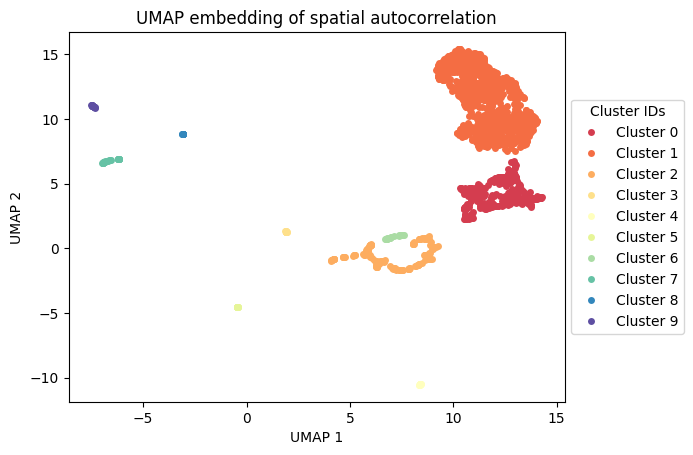

In [13]:
from sklearn.cluster import DBSCAN
import umap
umap_reducer_2d = umap.UMAP(n_components=2, random_state=10)
umap_embedding = umap_reducer_2d.fit_transform(spatial_autocorrelation_matrix.T)

# Clustering with DBSCAN
umap_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(umap_embedding)

# Plot each cluster
unique_labels = np.unique(umap_dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        # col = [0, 0, 0, 1]
        continue

    class_member_mask = (umap_dbscan.labels_ == k)

    xy = umap_embedding[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='none', markersize=5, label=f'Cluster {k}')  # Removed black edge

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP embedding of spatial autocorrelation")
plt.legend(title="Cluster IDs", loc='center left', bbox_to_anchor=(1, 0.5))  # Moved legend to the right
plt.show()

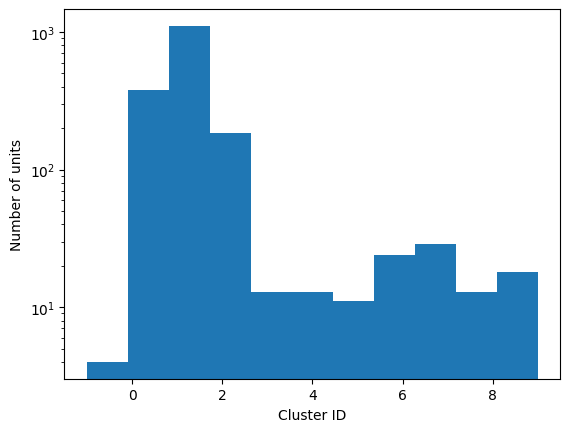

In [17]:
umap_clusters = umap_dbscan.fit_predict(umap_embedding)

def get_data_from_cluster(data,cluster_id):
    return data[umap_clusters == cluster_id]

clusters = {}

for i in np.unique(umap_clusters):
    cluster = get_data_from_cluster(activations['v'],i)
    clusters[i] = cluster

plt.hist(umap_clusters, bins=len(np.unique(umap_clusters)));
plt.xlabel("Cluster ID")
plt.ylabel("Number of units");
#log scale on y axis
plt.yscale("log")

There are 24 units in cluster 6


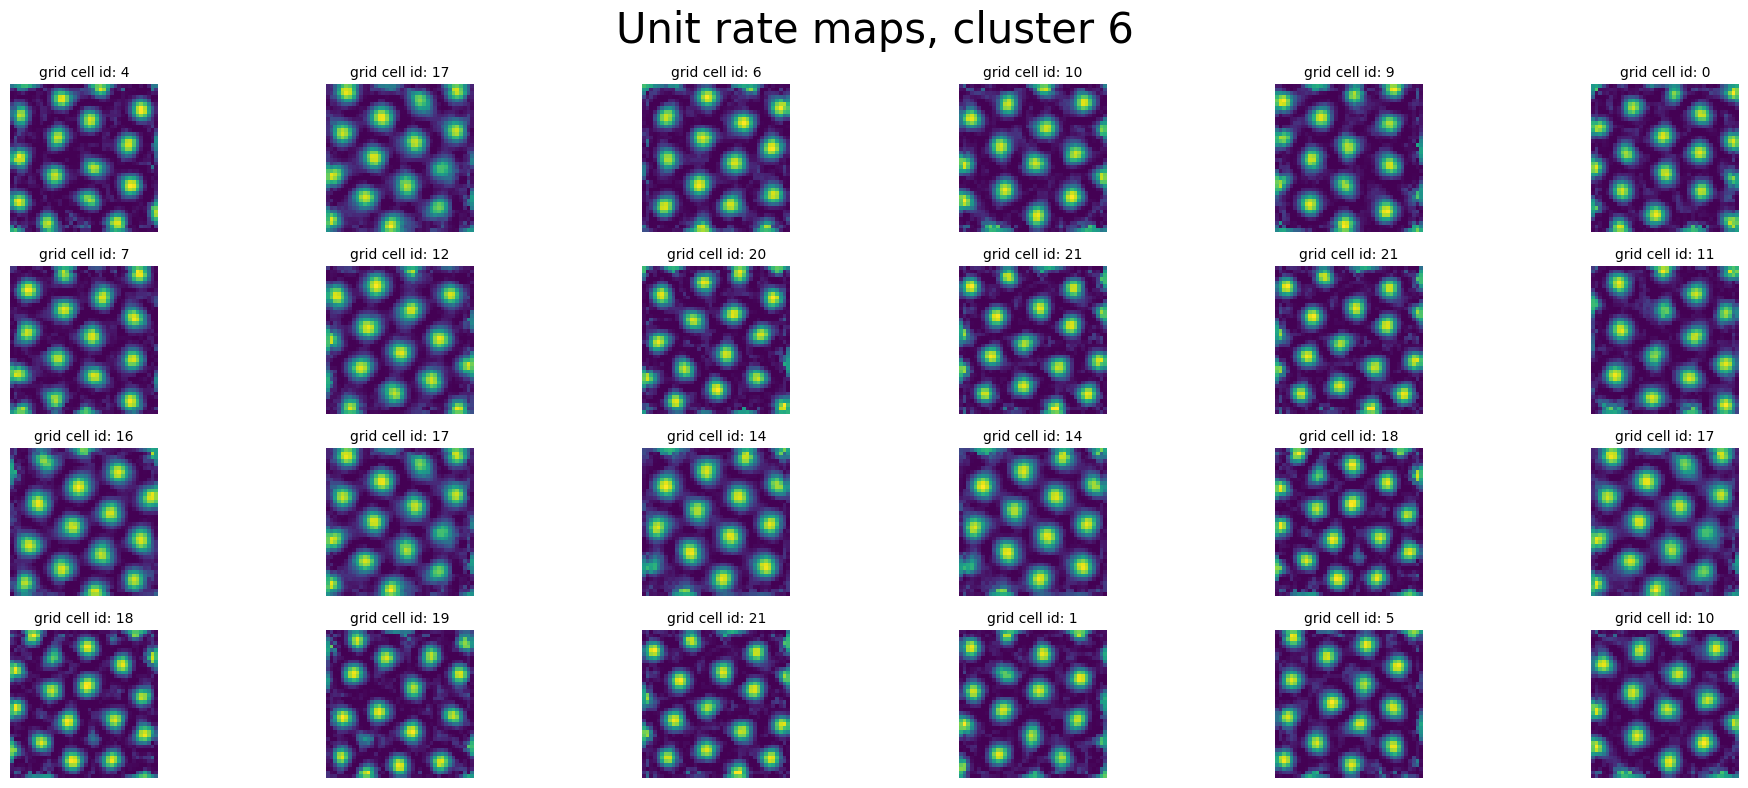

In [19]:
cluster_id = 6

num_cells_in_cluster = clusters[cluster_id].shape[0]
print(f"There are {num_cells_in_cluster} units in cluster {cluster_id}")

plot_rate_map(None, min(40,num_cells_in_cluster), clusters[cluster_id], f"Unit rate maps, cluster {cluster_id}")

In [20]:
neural_points = clusters[cluster_id].reshape(len(clusters[cluster_id]),-1).T
print(neural_points.shape)

(1600, 24)


### Cohomological Coordinates on Grid Cell Module Torus

In [25]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams
from sklearn.decomposition import PCA
pca = PCA(n_components=6)

neural_points_pca = pca.fit_transform(neural_points)
diagrams = compute_persistence_diagrams([neural_points_pca])

(1600, 6)


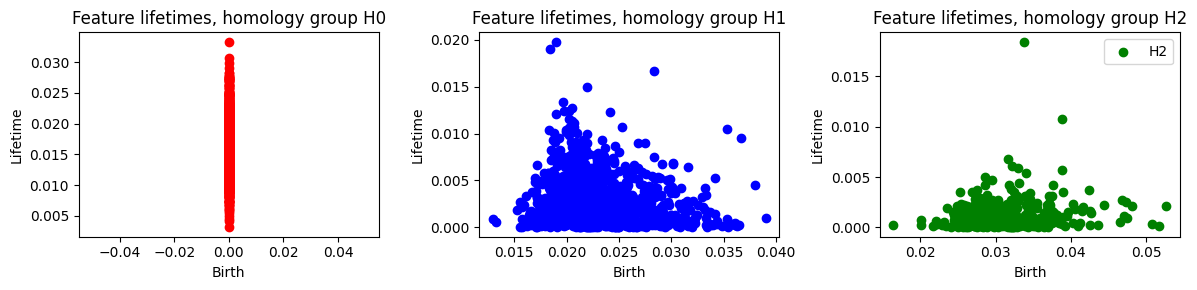

In [87]:
from neurometry.topology.persistent_homology import plot_lifetimes

plot_lifetimes(diagrams[0])

In [100]:
from neurometry.topology.persistent_homology import plot_activity_on_torus, cohomological_toroidal_coordinates

toroidal_coords = cohomological_toroidal_coordinates(neural_points_pca)
plot_activity_on_torus(neural_points, toroidal_coords, neuron_id=13)

### PCA / UMAP / Isomap

In [150]:
# visualize 3d projection of the neural points using pca and plotly

from sklearn.decomposition import PCA
from plotly import express as px

pca = PCA(n_components=3)
pca.fit(neural_points)
neural_points_pca = pca.transform(neural_points)

fig = px.scatter_3d(
    x=neural_points_pca[:, 0],
    y=neural_points_pca[:, 1],
    z=neural_points_pca[:, 2],
    opacity=1,
    title="3D PCA projection of neural points",
)

#change point size 
fig.update_traces(marker=dict(size=2))

fig.update_traces(marker=dict(color=Y[:,0]))

fig.show()

In [1]:
# visualize 3d projection of the neural points using umap and plotly

umap_reducer_3d = umap.UMAP(n_components=3, random_state=10)
umap_embedding_3d = umap_reducer_3d.fit_transform(neural_points)

fig = px.scatter_3d(
    x=umap_embedding_3d[:, 0],
    y=umap_embedding_3d[:, 1],
    z=umap_embedding_3d[:, 2],
    opacity=0.9,
    title="3D UMAP projection of neural points",
)

fig.update_traces(marker=dict(size=4))


fig.update_traces(marker=dict(color=neural_points[:,0]))

fig.show()

import plotly.io as pio

# Save the figure to an HTML file
#pio.write_html(fig, file='umap_3d_projection.html')

NameError: name 'umap' is not defined

### Dimensionality Estimation

(1600, 2)


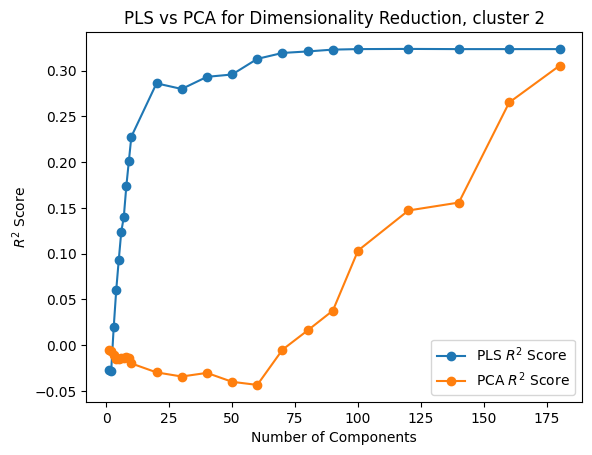

In [139]:
box_width = 1
res = 40

bin_edges = np.linspace(0, box_width, res + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_centers, y_centers = np.meshgrid(bin_centers, bin_centers[::-1])

positions_array = np.stack([x_centers, y_centers], axis=-1)

# Flatten the coordinate array to shape (400, 2)
positions = positions_array.reshape(-1, 2)


print(positions.shape)


X = neural_points
Y = positions

from neurometry.dimension.dimension import (
    evaluate_PCA_with_different_K,
    evaluate_pls_with_different_K,
)

K_values = [*range(1,10),*range(10,100,10),*range(100,200,20)]
# K_values = [*range(1,10),*range(10,30,5)]

pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)

pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)

plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")

plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")

plt.xlabel("Number of Components")

plt.ylabel("$R^2$ Score")

plt.title(f"PLS vs PCA for Dimensionality Reduction, cluster {cluster_id}")

plt.legend();

In [143]:
# visualize 3d projection of the neural points using pca and plotly

from sklearn.decomposition import PCA
from plotly import express as px

pca = PCA(n_components=3)
pca.fit(pls_transformed_X[20])
neural_points_pls_pca = pca.transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=neural_points_pca[:, 0],
    y=neural_points_pca[:, 1],
    z=neural_points_pca[:, 2],
    opacity=1,
    title="3D PCA projection of neural points",
)

#change point size 
fig.update_traces(marker=dict(size=2))

fig.update_traces(marker=dict(color=Y[:,0]))

fig.show()

In [144]:
# visualize 3d projection of the neural points using umap and plotly

umap_reducer_3d = umap.UMAP(n_components=3, random_state=10)
umap_embedding_3d = umap_reducer_3d.fit_transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=umap_embedding_3d[:, 0],
    y=umap_embedding_3d[:, 1],
    z=umap_embedding_3d[:, 2],
    opacity=0.7,
    title="3D UMAP projection of neural points",
)

fig.update_traces(marker=dict(size=4))


fig.update_traces(marker=dict(color=Y[:,1]))

fig.show()

In [145]:
# visualize 3d projection of the neural points using isomap and plotly

from sklearn.manifold import Isomap

isomap = Isomap(n_components=3)
isomap_embedding = isomap.fit_transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=isomap_embedding[:, 0],
    y=isomap_embedding[:, 1],
    z=isomap_embedding[:, 2],
    opacity=0.7,
    title="3D Isomap projection of neural points",
)

fig.update_traces(marker=dict(size=4))

fig.update_traces(marker=dict(color=Y[:,1]))

fig.show()

### Persistent Homology

In [146]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams
from gtda.plotting import plot_diagram

In [57]:
diagrams = compute_persistence_diagrams([neural_points])

fig = plot_diagram(diagrams[0])

fig.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; Full state space")

In [147]:
diagrams_pls = compute_persistence_diagrams([pls_transformed_X[20]])

In [69]:
fig_pls = plot_diagram(diagrams_pls[0])

fig_pls.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; PLS 40 components")

In [71]:
diagrams_pca = compute_persistence_diagrams([pca_transformed_X[5]])

plot_diagram(diagrams_pca[0])

fig_pls.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; PCA 6 components")

In [19]:
weighted_diagrams = compute_persistence_diagrams([neural_points], weighted=True)
plot_diagram(weighted_diagrams[0])